# **Library requirement**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install pandas # read csv
%pip install contractions #
%pip install pyspellchecker # check and replace mispell words
%pip install tensorflow
%pip install fasttext # train fasttext
%pip install nltk
%pip install matplotlib
%pip install pydot
%pip install scikeras
%pip install scikit-learn

Create folder save model

In [3]:
import os

foldername = 'lstm_glove_dim300_custom_final'

path = f'/content/drive/MyDrive/KLTN/model/${foldername}'
if not os.path.exists(path):
  os.mkdir(path)

In [4]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import (
    LSTM,
    Embedding,
    Dense,
    Input,
    GlobalMaxPooling1D,
    Dropout,
    Bidirectional,
    SpatialDropout1D,
    CuDNNLSTM
)
from keras.models import Model, Sequential
import pandas as pd
import fasttext
import numpy as np
from keras import regularizers

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score ,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics as m

from tensorflow.keras.callbacks import EarlyStopping


# **Preprogress Data**


**Clean Text**


In [5]:
# from spellchecker import SpellChecker
import contractions
import urllib.parse
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


class CleanText:

    def __init__(self):
        # self.eng_checker = SpellChecker(language='en')
        self.lemmatizer = nltk.WordNetLemmatizer()
        nltk_stopwords = stopwords.words('english')
        negative_words = ['not', 'no', 'never', 'nor',
                          # location words
                          "off", "out", "over", "under", "up", "down",]
        self.stop_words = [
            word for word in nltk_stopwords if word not in negative_words]

    def _lower_case(self, text):
        return text.lower()

    def _check_url(self, url):
        # check if the url is valid or not
        parsed = urllib.parse.urlparse(url)
        return bool(parsed.scheme and parsed.netloc)

    def _remove_html(self, text):
        # remove all the html tags
        result = text.replace('<.*?>', '')
        return result

    def _expaned_contractions(self, text):
        return contractions.fix(text)

    def _remove_emails(self, text):
        return text.replace(r"[\w\.-]+@[\w\.-]+\.\w+", "")

    def _change_user_name(self, text):
        pattern = re.compile(r"@\w+")
        return re.sub(pattern, "user", text)

    def _replace_urls(self, text):
        # Replace URLs with 'url'
        return re.sub(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?', 'url', text)

    def _replace_symbol_to_space(self, text):
        # replace all the symbols to space
        return re.sub(r'[^\w\s]', ' ', text)

    def _remove_single_char(self, text):
        # remove all the single characters
        return re.sub(r'\b(?<![a-hj-z])[a-z](?![a-z])\b', ' ', text)

    def _remove_multiple_space(self, text):
        # remove all the multiple spaces
        return re.sub(r'\s+', ' ', text)

    def _remove_number(self, text):
        return re.sub(r'[0-9]', '', text)

    def _remove_repeat_word(self, text):
        # remove all the characters that appear more than 2 times in a word
        return re.sub(r'(.)\1+', r'\1\1', text)

    def _fit_word(self, text):
        # Replace misplassed words
        words = text.split()
        words = [self._correct_word(word) for word in words]
        return ' '.join(words)

    def _correct_word(self, text):
        fixed = self.eng_checker.correction(text)
        if fixed != None:
            return fixed
        return text

    def _remove_emoji(self, text):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    def _remove_stopwords(self, text):
        # Remove stopwords
        word_tokens = nltk.word_tokenize(text)
        filtered_text = [w for w in word_tokens if w not in self.stop_words]
        return ' '.join(filtered_text)

    def _lemmatize_text(self, text):
        # Lemmatize the text
        output=""
        text=text.split(" ")
        for word in text:
          word1 = self.lemmatizer.lemmatize(word, pos = "n")
          word2 = self.lemmatizer.lemmatize(word1, pos = "v")
          word3 = self.lemmatizer.lemmatize(word2, pos = "a")
          word4 = self.lemmatizer.lemmatize(word3, pos = "r")
          output=output + " " + word4
        return str(output.strip())

    def _fit_in_alphabet(self, text):
        regex = re.compile('[^a-zA-Z]')
        # First parameter is the replacement, second parameter is your input string
        return regex.sub(' ', text)

    def clean_lstm(self, text):

        # lọc nhiễu
        text = self._lower_case(text)
        text = self._remove_html(text)
        text = self._replace_urls(text)
        text = self._remove_emails(text)
        text = self._change_user_name(text)
        text = self._remove_emoji(text)
        text = self._remove_repeat_word(text)

        # chuẩn hóa

        text = self._expaned_contractions(text)
        # text = self._fit_word(text)
        text = self._remove_stopwords(text)
        text = self._fit_in_alphabet(text)
        text = self._lemmatize_text(text)

        # loại bỏ phần không cần thiết
        text = self._remove_single_char(text)
        text = self._remove_multiple_space(text)

        return text.strip()

    def clean_w2v(self, text):
        # lọc nhiễu
        text = self._lower_case(text)
        text = self._remove_html(text)
        text = self._replace_urls(text)
        text = self._remove_emails(text)
        text = self._change_user_name(text)
        text = self._remove_emoji(text)
        text = self._remove_repeat_word(text)
        text = self._remove_unicode_chars(text)
        text = self._remove_number(text)

        # chuẩn hóa
        text = self._expaned_contractions(text)

        # loại bỏ phần không cần thiết
        text = self._remove_single_char(text)
        text = self._fit_in_alphabet(text)

        return text.strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Import data**

In [6]:
TRAINING_DATA_LOC = '/content/drive/MyDrive/KLTN/data/preprogress/train_clean_aug.csv'

training_data = pd.read_csv(TRAINING_DATA_LOC).fillna('no comment')
training_data.drop_duplicates(subset='cleaned_text')

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,target
0,72531,c218d82a89df572a,"""\nWatch it: Palestinian national radio puts o...",1,0,1,0,1,1,watch palestinian national radio put out call ...,1
1,33352,58e66a3223ce6466,"Self-appointed, self-aggrandising and self-imp...",1,0,0,0,0,0,self appoint self aggrandise self important gu...,1
2,99983,172167501c93fe9f,"""\n\nWhy on earth do you think I give a fuck a...",1,0,1,0,0,0,earth think give fuck opinion especially wrong...,1
3,104039,2ca984b3dc59249b,Who made you sherrif you shitsack?,1,0,1,0,1,0,make sherrif shitsack,1
4,58697,9d3373992b529265,"""\n\nHey Rent, thanks for the suggestion. It's...",0,0,0,0,0,0,hey rent thank suggestion funny mention it by ...,0
...,...,...,...,...,...,...,...,...,...,...,...
224446,189135,c148e354da59889f,"DP \n\nFuck you, who the hell do you think you...",1,0,1,0,1,0,dp fuck hell think prepare line every football...,1
224447,106837,3b5266748bf3d1a8,"""\n\nDispute resolution\nPlease read our Wikip...",0,0,0,0,0,0,dispute resolution please read wikipedia dispu...,0
224448,171077,49e20adf76b0e22a,Boring\n\nWhy are you so boring Gail.. stop ha...,1,0,0,0,0,0,bore bore gail full stop harass,1
224449,44670,775d4c8bcbc31cdb,"""71.174.32.235 Dear HJ, do you represent the ...",0,0,0,0,0,0,dear hj represent wikipedia censorship brigade...,0


In [7]:
detection_classes = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate"
]

In [8]:
toxic_df = training_data[training_data.target == 1].reset_index(drop=True)
non_toxic_df = training_data[training_data.target == 0].reset_index(drop=True)
non_toxic_df = non_toxic_df.sample(n=len(toxic_df))
training_data = pd.concat([toxic_df, non_toxic_df], axis=0).reset_index(drop=True)
training_data = training_data.sample(frac=1)

In [9]:
training_data['target'].value_counts()

1    81105
0    81105
Name: target, dtype: int64

In [10]:
comments = training_data["cleaned_text"].values

target_classes = training_data[detection_classes].values

# **Train LSTM**


In [11]:
EMBEDDING_FILE_LOC = "/content/drive/MyDrive/KLTN/data/glove.42B.300d.txt"
EMBEDDING_DIMENSION = 300  # Dimension of word vectors
MAX_VOCAB_SIZE = 20000  # max number of words to keep, based on word frequency
MAX_SEQUENCE_LENGTH = 300  # max number of words in a comment to use
BATCH_SIZE = 32
EPOCHS = 16

### Import GloVe

In [12]:
word_to_vector = {}
with open(EMBEDDING_FILE_LOC) as file:
    # A space-separated text file in the format
    # word vec[0] vec[1] vec[2] ...
    for line in file:
        word = line.split()[0]
        word_vec = line.split()[1:]

        # converting word_vec into numpy array
        # adding it in the word_to_vector dictionary
        word_to_vector[word] = np.asarray(word_vec, dtype='float32')

    # print the total words found
    print(f'Total of {len(word_to_vector)} word vectors are found.')

Total of 1917495 word vectors are found.


### Splitting data into Training and Validation Set

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                       comments , target_classes,
                test_size = 0.30, random_state = 42)

## Data Preprocessing Steps


### Convert Comments (Strings) into Integers


In [14]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

Save tokenizer


In [15]:
import pickle

# Save the tokenizer
with open(f"{path}/tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Word to Integer Mapping


In [16]:
word_to_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_to_index))

Found 92074 unique tokens.


#### Padding Sequences to a N x T Matrix


In [17]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_tr = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH)

x_test_sequences = tokenizer.texts_to_sequences(X_test)
X_te = pad_sequences(x_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print("Shape of data tensor:", X_tr.shape)
print("Shape of data tensor:", X_te.shape)

Shape of data tensor: (113547, 300)
Shape of data tensor: (48663, 300)


#### Preparation of Embedding Matrix


In [18]:
num_words = min(MAX_VOCAB_SIZE, len(word_to_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIMENSION))
for word, i in word_to_index.items():
    if i < num_words:
        embedding_vector = word_to_vector.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

## **Create model**

### Train the LSTM model


##### Load Pre-Trained Word Embeddings into an Embedding Layer


In [19]:
def build_model():
  model = Sequential()

  model.add(Embedding(
    input_dim=num_words,
    output_dim=EMBEDDING_DIMENSION,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False,
    name = 'embeddings'
    ))
  model.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2))
  model.add(Dense(30, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(6, activation="sigmoid"))
  return model

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [21]:
model = build_model()
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["accuracy"])
# model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 300, 300)          6000000   
                                                                 
 lstm (LSTM)                 (None, 300, 100)          160400    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 30)                3030      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                        

In [23]:
from contextlib import redirect_stdout

with open(f'{path}/model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

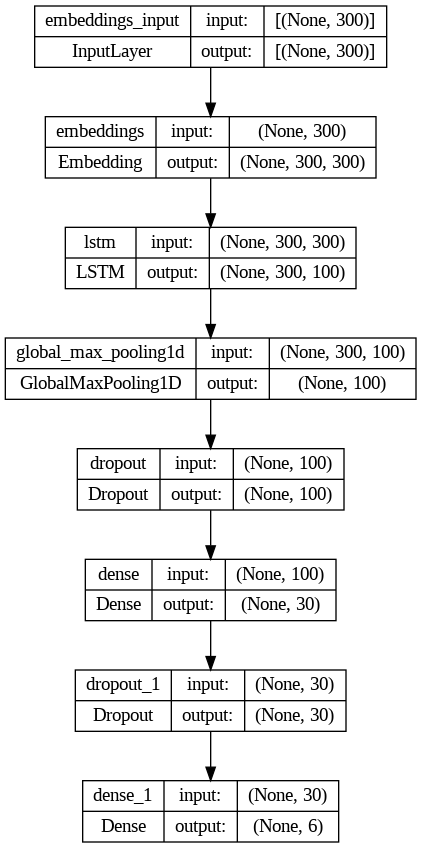

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file=f"{path}/model.png", show_shapes=True)

In [25]:
lstm_model = model.fit(
    X_tr,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_te,y_test),
    # callbacks=[earlyStop],
    # shuffle=False
)

Epoch 1/16
3549/3549 [==============================] - 1143s 321ms/step - loss: 0.2576 - accuracy: 0.8712 - val_loss: 0.1946 - val_accuracy: 0.9708
Epoch 2/16
3549/3549 [==============================] - 1157s 326ms/step - loss: 0.2033 - accuracy: 0.9547 - val_loss: 0.1804 - val_accuracy: 0.9708
Epoch 3/16
3549/3549 [==============================] - 1176s 331ms/step - loss: 0.1910 - accuracy: 0.9643 - val_loss: 0.1732 - val_accuracy: 0.9708
Epoch 4/16
3549/3549 [==============================] - 1166s 328ms/step - loss: 0.1824 - accuracy: 0.9636 - val_loss: 0.1661 - val_accuracy: 0.9708
Epoch 5/16
3549/3549 [==============================] - 1155s 325ms/step - loss: 0.1757 - accuracy: 0.9614 - val_loss: 0.1615 - val_accuracy: 0.9708
Epoch 6/16
3549/3549 [==============================] - 1144s 322ms/step - loss: 0.1712 - accuracy: 0.9605 - val_loss: 0.1579 - val_accuracy: 0.9708
Epoch 7/16
3549/3549 [==============================] - 1124s 317ms/step - loss: 0.1671 - accuracy: 0.9619

In [48]:
# save model
model.save(f"{path}/glove_lstm.h5")

### Evaluator model

##### Average ROC_AUC Score

In [27]:
from sklearn.metrics import roc_auc_score

In [28]:
p = model.predict(X_te)
aucs = []
for j in range(6):
    auc = roc_auc_score(y_test[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

1521/1521 [==============================] - 106s 70ms/step
0.9669072950577581


In [29]:


plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (15, 10)

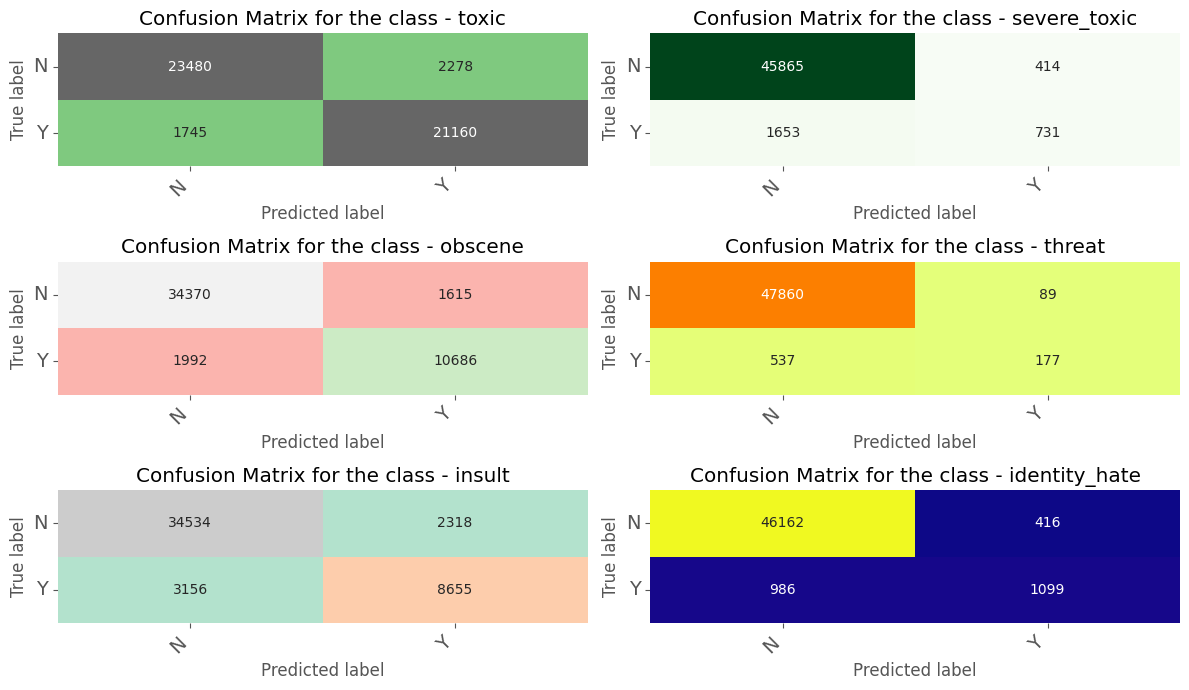

In [30]:
cfs = []
for i in range(6):
    y_pred = np.where(p[:,i] > 0.5, 1, 0)
    cf = np.asarray(confusion_matrix(y_test[:,i], y_pred))
    cfs.append(cf)

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names,c,fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    heatmap = sns.heatmap(df_cm, annot=True,cmap=c, fmt="d", cbar=False, ax=axes)


    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

    axes.set_ylabel('True label')

    axes.set_xlabel('Predicted label')

    axes.set_title("Confusion Matrix for the class - " + class_label)

fig, ax = plt.subplots(3, 2, figsize=(12, 7))

cmaps = ['Accent','Greens','Pastel1','Wistia','Pastel2','plasma']

for axes, cfs_matrix, label, i in zip(ax.flatten(), cfs, detection_classes,range(6)):

    c = cmaps[i]

    print_confusion_matrix(cfs_matrix, axes, label,["N", "Y"],c,14)


fig.tight_layout()

plt.show()

In [31]:
y_pred = [np.where(p_col > 0.5, 1, 0) for p_col in p]
cr = pd.DataFrame(classification_report(y_test,y_pred, target_names=detection_classes,output_dict=True)).T
cr['support'] = cr.support.apply(int)
cr.style.background_gradient(cmap='Pastel1')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
toxic,0.902807,0.923816,0.913191,22905
severe_toxic,0.638428,0.306628,0.414282,2384
obscene,0.868710,0.842877,0.855599,12678
threat,0.665414,0.247899,0.361224,714
insult,0.788754,0.732791,0.759744,11811
identity_hate,0.725413,0.527098,0.610556,2085
micro avg,0.856360,0.808490,0.831737,52577
macro avg,0.764921,0.596852,0.652432,52577
weighted avg,0.846718,0.808490,0.822714,52577
samples avg,0.405563,0.396215,0.388829,52577


##### Plot the training and validation loss


In [32]:
import matplotlib.pyplot as plt

Plotting Accuracy


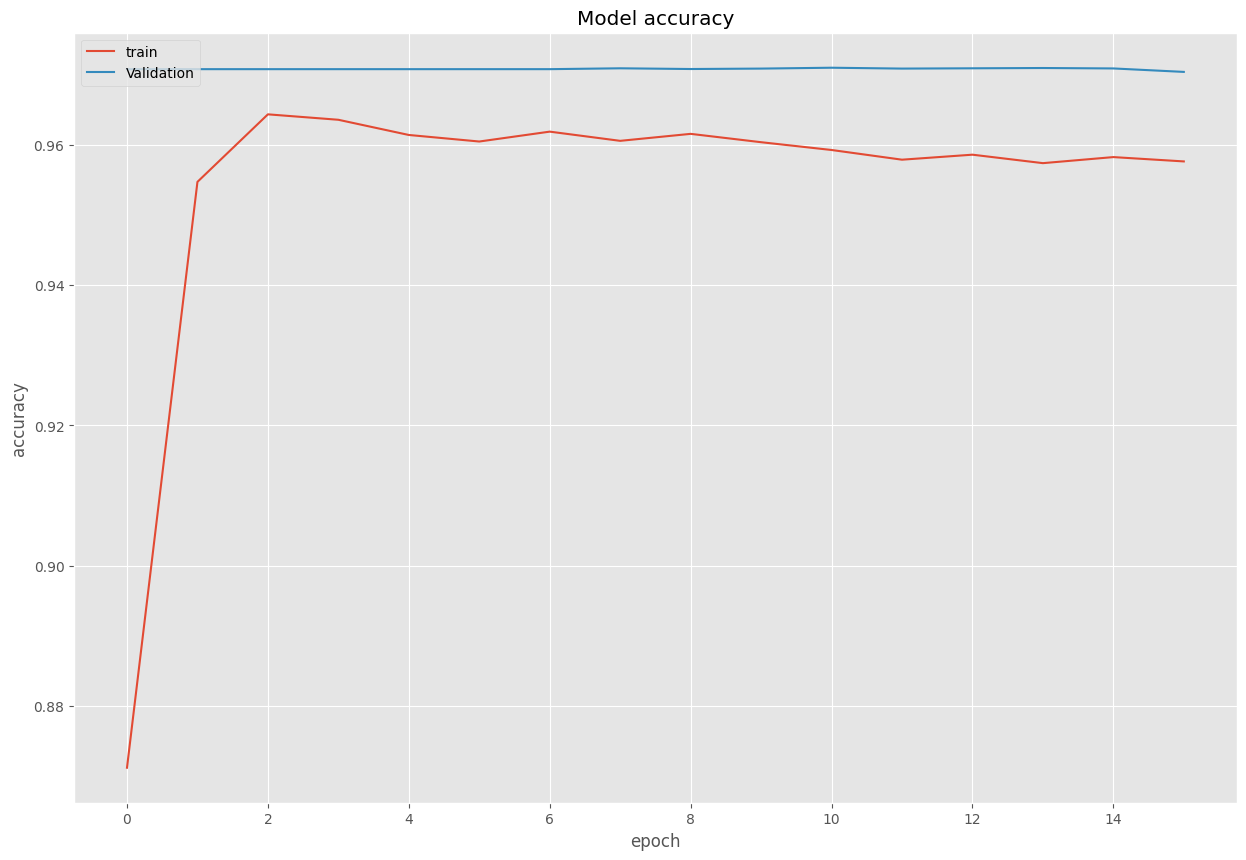

In [33]:
plt.plot(lstm_model.history["accuracy"])
plt.plot(lstm_model.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "Validation"], loc="upper left")
plt.savefig(
    f"{path}/toxic_model_fasttext_lstm_accuracy.png"
)

plt.show()

Plotting Loss


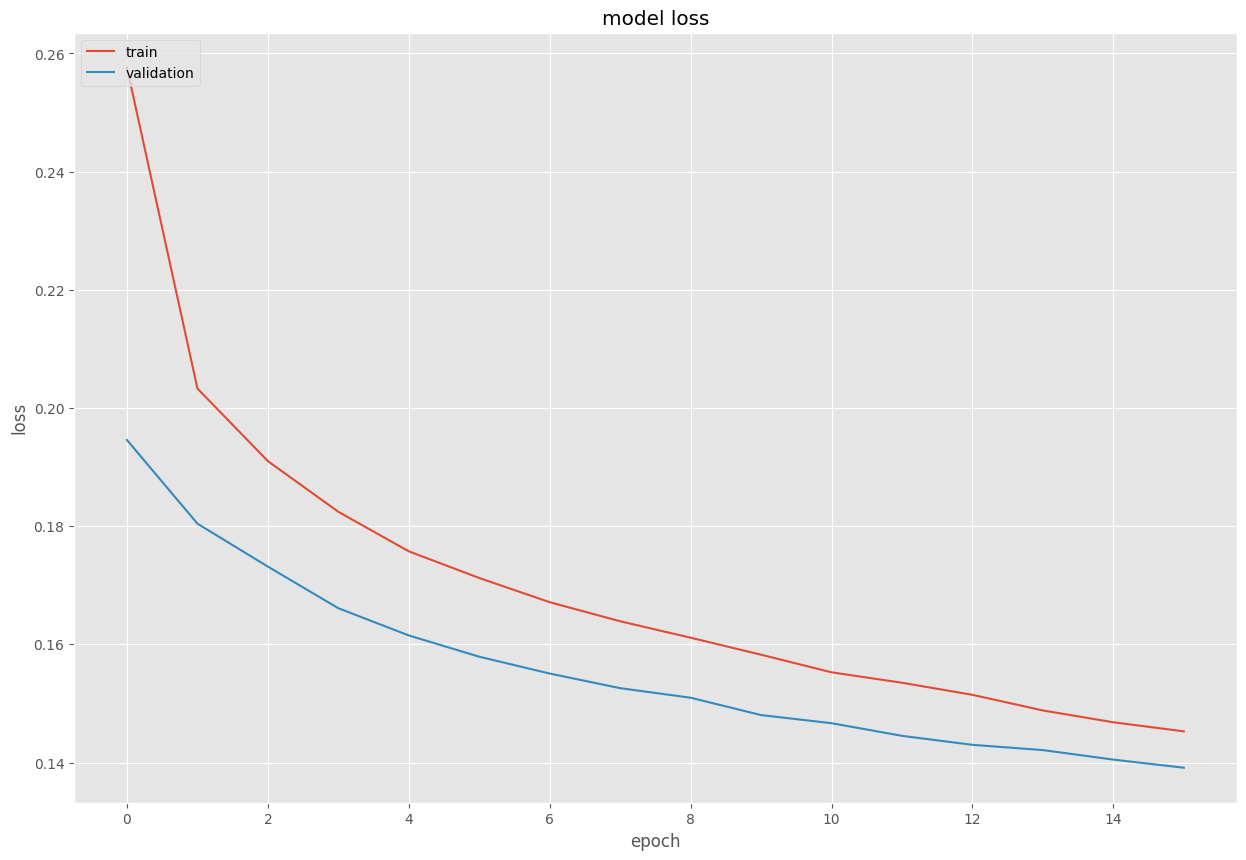

In [34]:
plt.plot(lstm_model.history["loss"])
plt.plot(lstm_model.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.savefig(
    f"{path}/toxic_model_fasttext_lstm_los.png"
)

plt.show()

**Predict**


In [35]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import fasttext
import pickle

# Load FastText word embeddings
# embedding_path = "/home/nlp/nlp/li/output/fb_model_dim100_v1.bin"
# embeddings = fasttext.load_model(embedding_path)


# Load the trained LSTM model
lstm_model = load_model(f"{path}/fasttext_lstm.h5")

# Load the tokenizer


cleaner = CleanText()

# tokenizer = pickle.load(open("tokenizer.pickle", "rb"))

# Create a function to predict the toxicity of a comment
def predict_toxicity(comment):
    # Preprocess the comment
    comment = cleaner.clean_lstm(comment)
    print(comment)
    comment = tokenizer.texts_to_sequences([comment])
    comment = pad_sequences(comment, maxlen=300)
    # Predict the toxicity
    prediction = lstm_model.predict(comment)[0]
    # Return the predicted toxicity

    return prediction

In [36]:
def print_predict(result):
  print(f"toxic: {result[0]*100}")
  print(f"severe_toxic: {result[1]*100}")
  print(f"obscene: {result[2]*100}")
  print(f"threat: {result[3]*100}")
  print(f"insult: {result[4]*100}")
  print(f"identity_hate: {result[5]*100}")

In [37]:
result = predict_toxicity(comment="""
Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,
""")

print_predict(result)


yo bitch ja rule succesful ever up hat sad mofuckas bitch slap pethedic white face get kiss as guy sicken ja rule pride da music man not dis shit nothin wrong bein like tupac brother fuckin white boy get thing right next time
1/1 [==============================] - 0s 382ms/step
toxic: 99.70993995666504
severe_toxic: 48.75984787940979
obscene: 97.86257147789001
threat: 19.174431264400482
insult: 93.66112351417542
identity_hate: 63.472533226013184


In [38]:
result = predict_toxicity(comment="""
fuck face
""")
print_predict(result)

fuck face
1/1 [==============================] - 0s 65ms/step
toxic: 99.51147437095642
severe_toxic: 20.66211849451065
obscene: 97.43591547012329
threat: 0.7800554856657982
insult: 67.56193041801453
identity_hate: 2.1087968721985817


In [39]:
result = predict_toxicity(comment="""
 suck my dick
""")
print_predict(result)

suck dick
1/1 [==============================] - 0s 76ms/step
toxic: 99.68327283859253
severe_toxic: 33.403655886650085
obscene: 97.31837511062622
threat: 0.820788461714983
insult: 79.61481809616089
identity_hate: 2.5858258828520775


In [40]:
result = predict_toxicity(comment="""
  Recently, a different usage of the word gay has appeared in Australian English. In addition to the earlier meaning of gay being ‘happy’, ‘carefree’ and ‘frivolous’ (1st meaning), and to a later meaning of gay being synonymous with ‘homosexual’ (2nd meaning), it appears that gay is now being understood by young people to mean ‘stupid’, ‘lame’ or ‘boring’, as in ‘That shirt is so gay’, or ‘How gay is that?’ (3rd meaning). Two studies were performed to ascertain who is aware of this new meaning of gay within contemporary Australian society (Study 1) and to examine the 3rd meaning in more detail, by focussing on how young people from Canberra (Australia), aged 18–30, currently understand the word gay (Study 2)
""")
print_predict(result)

recently different usage word gay appear australian english addition early mean gay happy carefree frivolous st mean late mean gay synonymous homosexual nd mean appear gay understand young people mean stupid lame bore shirt gay gay rd mean two study perform ascertain aware new mean gay within contemporary australian society study examine rd mean detail focus young people canberra australia age currently understand word gay study
1/1 [==============================] - 0s 63ms/step
toxic: 57.30237364768982
severe_toxic: 0.007584608829347417
obscene: 2.8746765106916428
threat: 0.008578065171604976
insult: 11.489320546388626
identity_hate: 12.540043890476227


In [41]:
result2 = predict_toxicity(comment="""
  , 25 February 2010 (UTC)

 :::Looking it over, it's clear that  (a banned sockpuppet of ) ignored the consensus (&, fwiw, policy-appropriate) choice to leave the page at Chihuahua (Mexico) and the current page should be returned there. Anyone have the time to fix the incoming links? -  18:24
""")
print_predict(result2)

february utc look over clear ban sockpuppet ignore consensus fwiw policy appropriate choice leave page chihuahua mexico current page return anyone time fix incoming link
1/1 [==============================] - 0s 70ms/step
toxic: 0.35993626806885004
severe_toxic: 2.287821843083293e-06
obscene: 0.013159563241060823
threat: 4.573098237869999e-05
insult: 0.01714374520815909
identity_hate: 0.00018708504967435147


In [42]:
result = predict_toxicity(comment="i love u")
print_predict(result)

love
1/1 [==============================] - 0s 67ms/step
toxic: 23.198364675045013
severe_toxic: 0.9626558050513268
obscene: 7.78067484498024
threat: 2.262171357870102
insult: 7.847464829683304
identity_hate: 1.7659280449151993


In [43]:
result2 = predict_toxicity(comment="""
  i will kill u
""")
print_predict(result2)

kill
1/1 [==============================] - 0s 55ms/step
toxic: 85.97938418388367
severe_toxic: 5.502249300479889
obscene: 12.525807321071625
threat: 56.04588985443115
insult: 28.54577600955963
identity_hate: 5.909141525626183


In [44]:
result2 = predict_toxicity(comment="""
  bleeding me dry like a vampire
""")
print_predict(result2)

bleed dry like vampire
1/1 [==============================] - 0s 63ms/step
toxic: 88.85025978088379
severe_toxic: 1.9926128908991814
obscene: 19.926747679710388
threat: 4.001457989215851
insult: 29.099848866462708
identity_hate: 2.5366773828864098


In [45]:
result2 = predict_toxicity(comment="""
   mom, i home
""")
print_predict(result2)

mom home
1/1 [==============================] - 0s 55ms/step
toxic: 62.136465311050415
severe_toxic: 0.6271890830248594
obscene: 13.015897572040558
threat: 0.4150528460741043
insult: 17.558740079402924
identity_hate: 0.6843226030468941


In [47]:
result2 = predict_toxicity(comment="""
   i will follow u and kill u
""")
print_predict(result2)

follow kill
1/1 [==============================] - 0s 78ms/step
toxic: 84.2960774898529
severe_toxic: 4.030808806419373
obscene: 9.301270544528961
threat: 55.287885665893555
insult: 24.855971336364746
identity_hate: 4.465389996767044
